In [46]:
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as td 
from celluloid import Camera
from IPython.display import HTML

from numpy import sin
from numpy import cos 
from numpy import pi
from numpy import exp


%matplotlib inline

def LinearSWEconstants(H_bar,U_bar, g):
    lambda1 = -(1/(2*g*H_bar))*np.sqrt(U_bar**2*(g+H_bar)**2 + 4*g*H_bar*( g*H_bar - U_bar**2)) + U_bar*(g+H_bar)/(2*g*H_bar)
    lambda2 =  (1/(2*g*H_bar))*np.sqrt(U_bar**2*(g+H_bar)**2 + 4*g*H_bar*( g*H_bar - U_bar**2)) + U_bar*(g+H_bar)/(2*g*H_bar)
    c = (np.sqrt((lambda1 - U_bar/g)**2 + 1))
    d = (np.sqrt((lambda2 - U_bar/g)**2 + 1))
    return lambda1,lambda2,c,d

def BoundaryCondition(H_bar,U_bar, g):
    '''Setting up the boundary condition'''
    lambda1,lambda2,c,d = LinearSWEconstants(H_bar,U_bar, g)

    ##---------------------------------------------------------------------------------------##
    ## Outflow boundary condition
    p_0 = (1/c)*(np.sqrt(g/H_bar)*(lambda1 - U_bar/g) + 1)
    q_0 = (1/d)*(np.sqrt(g/H_bar)*(lambda2 - U_bar/g) + 1)

    p_N = (1/c)*(-np.sqrt(g/H_bar)*(lambda1 - U_bar/g) + 1)
    q_N = (1/d)*(-np.sqrt(g/H_bar)*(lambda2 - U_bar/g) + 1)
    
    ##---------------------------------------------------------------------------------------##

    ##---------------------------------------------------------------------------------------##
    ##  H_bar u + U_bar h = 0
    #p_N = 1/d*(H_bar + U_bar*(lambda2 - U_bar/g))
    #q_N = 1/c*(H_bar + U_bar*(lambda1 - U_bar/g))
    ##  H_bar u + U_bar h = 0
    #q_0 = 1/d*(H_bar + U_bar*(lambda2 - U_bar/g))
    #p_0 = 1/c*(H_bar + U_bar*(lambda1 - U_bar/g))
    ##---------------------------------------------------------------------------------------##

    ##---------------------------------------------------------------------------------------##
    #
    # h = 0 at x = 1
    # p_N = 1/c*(lambda1 - U_bar/g)
    # q_N = 1/d*(lambda2 - U_bar/g)
    # gammaN = - q_N/p_N         # h =0     / 
    #
    #
    # u = 0 at x = 1
    # p_N = 1/c
    # q_N = 1/d
    gammaN = - c/d           # u = 0    
    #
    ##---------------------------------------------------------------------------------------##
    
    # Boundary condition


    # q_0 = 1/d*(H_bar + U_bar*(lambda2 - U_bar/g))
    # p_0 = 1/c*(H_bar + U_bar*(lambda1 - U_bar/g)) # H_bar * u + U_bar * h = 0

    # p_N = 1/c*((lambda1 - U_bar/g))
    # q_N = 1/d*((lambda2 - U_bar/g))           # ?


    # q_N = (1/d)*(lambda2 - U_bar/g + 1)
    # p_N = (1/c)*(lambda1 - U_bar/g + 1)     # ? recheck


    # gamma0 = - p_0/q_0
    #gammaN = - p_N/q_N         #  H_bar u + U_bar h = 0

    # gammaN = - q_0/p_0          # H_bar u + U_bar h = 0
    
    gamma0 = -p_0/q_0 
    # gammaN = -q_N/p_N 
    return gamma0, gammaN

def BoundaryTerms(h,u,H_bar,U_bar,g, h_analytic, u_analytic):
    '''Set up the Boundary Condition'''
    lambda1,lambda2,c,d = LinearSWEconstants(H_bar,U_bar, g)
    gamma0, gammaN = BoundaryCondition(H_bar,U_bar, g)
    w_1 = ((h-h_analytic)*(lambda1 - U_bar/g)/c) + (u-u_analytic)/c
    w_2 = ((h-h_analytic)*(lambda2 - U_bar/g)/d) + (u-u_analytic)/d
    BC_0 = (w_2[0]-gamma0*w_1[0])
    BC_N = (w_1[-1]-gammaN*w_2[-1])
    # return 0,0
    return BC_0, BC_N

def penaltyparameter(H_bar,U_bar, g):
    lambda1,lambda2,c,d = LinearSWEconstants(H_bar,U_bar, g)
    tau_01 = H_bar*lambda2*(lambda2 - U_bar/g)/d
    tau_02 = g*(lambda2)/d
    tau_N1 = - H_bar*lambda1*(lambda1 - U_bar/g)/c
    tau_N2 = - lambda1*g/c 
    tau = [tau_01,tau_N1,tau_02,tau_N2]
    #return [0,0,0,0]
    return tau

def RHS(x,t,h,u,H_bar,U_bar,g,Q,A,H_inv,alpha,tau,e0,eN, mms):
    
    if mms != 0:
        h_analytic, u_analytic, f1, f2 = manufacturedsolution(x,t, H_bar,U_bar, g, L=1, C0 = 0, C1=0)
    else: 
        h_analytic, u_analytic, f1, f2 = 0, 0, 0, 0

    tau_01,tau_N1,tau_02,tau_N2 = tau
    
    BC_0, BC_N = BoundaryTerms(h,u,H_bar,U_bar,g, h_analytic, u_analytic)
    
    RHS_h = U_bar*(Q)@h + H_bar*(Q)@u + alpha*A@h 
    RHS_u =     g*(Q)@h + U_bar*(Q)@u + alpha*A@u 
    RHS_h = H_inv@(RHS_h + tau_01*e0*BC_0 + tau_N1*eN*BC_N) - f1
    RHS_u = H_inv@(RHS_u + tau_02*e0*BC_0 + tau_N2*eN*BC_N) - f2
    return -RHS_h,-RHS_u

def rk4(x, dt, t, h,u,H_bar,U_bar,g,Q,A,H_inv,alpha,tau,e0,eN, mms):
    f1_h, f1_u = RHS(x, t        ,h              , u               ,H_bar,U_bar,g,Q,A,H_inv,alpha,tau,e0,eN, mms)
    f2_h, f2_u = RHS(x, t + dt/2, h + (f1_h*dt)/2, u + (f1_u*dt)/2 ,H_bar,U_bar,g,Q,A,H_inv,alpha,tau,e0,eN, mms)
    f3_h, f3_u = RHS(x, t + dt/2, h + (f2_h*dt)/2, u + (f2_u*dt)/2 ,H_bar,U_bar,g,Q,A,H_inv,alpha,tau,e0,eN, mms)
    f4_h, f4_u = RHS(x, t + dt  , h + (f3_h*dt)  , u + (f3_u*dt)   ,H_bar,U_bar,g,Q,A,H_inv,alpha,tau,e0,eN, mms)
    h += (dt/6)* (f1_h + 2*f2_h + 2*f3_h + f4_h)
    u += (dt/6)* (f1_u + 2*f2_u + 2*f3_u + f4_u)
    return h, u


def LinearizedSWE(x, dx, n, dt, h,u,H_bar, U_bar, cfl, finaltime, alpha, mms, stack_solution):
    '''Linearized Shallow Water Equation
    Input: x: vector            = discretize domain
           dx: scalar (for now) = length of grid cells
           n: integer           = number of grid cells
           h: vector            = initial water depth (perturbation)
           u: vector            = initial speed (perturbation)
           H_bar: scalar        = average height
           U_bar: scalar        = average speed
           dt: scalar           = time step
           finaltime: scalar    = time to simulating
           alpha : scalar       = dissipative coefficient
           BC: [gamma0, gammaN] = set boundary condition
           tau: [tau_01,tau_N1,tau_02,tau_N2] = penalty coefficient   
    '''
    
        #-------------------------------------------------------------------------------------------------#
    # supportive
    # creating matrix Q, H, A, e0 and eN
    # also defining the constant g

    J1 = np.block([[np.zeros(n)],[-np.diag(np.ones(n-2)),np.zeros((n-2,2))],[np.zeros(n)]])
    J2 = np.block([[np.zeros(n)],[np.zeros((n-2,2)),np.diag(np.ones(n-2))],[np.zeros(n)]])
    Diag = np.block([[np.zeros(n)],[np.zeros((n-2,1)),np.diag(np.ones(n-2)),np.zeros((n-2,1))],[np.zeros(n)]])

    Q = np.zeros((n,n))
    Q[0,0]     = -1 
    Q[0,1]     =  1
    Q[-1,-1]   =  1
    Q[-1,-2]   = -1
    Q += J1 + J2
    Q *= 0.5

    A = np.zeros((n,n))
    A[0,0]     =  1 
    A[0,1]     = -1
    A[-1,-1]   = 1
    A[-1,-2]   = -1
    A += (J1 - J2) + 2*Diag


    H_notheight =   (dx) * np.diag(np.block([1/2, np.ones(n-2), 1/2]))
    H_inv       = (1/dx) *(np.diag(np.block([  2, np.ones(n-2),   2])))

    Dx = H_inv@Q

    e0 = np.zeros(n)
    e0[0]=1
    eN = np.zeros(n)
    eN[-1]=1
    g = 9.8
    
    # end supportive 
    #-------------------------------------------------------------------------------------------------#
    # Calling the Boundary Condition, 
    # boundary terms and penalty parameter

    print('Initialized the Boundary')
    lambda1,lambda2,c,d = LinearSWEconstants(H_bar,U_bar, g)
    tau = penaltyparameter(H_bar,U_bar, g)
    gamma0, gammaN = BoundaryCondition(H_bar,U_bar, g)

    #-------------------------------------------------------------------------------------------------#

    print('Calculating solution')    
    counter = np.int32(finaltime/dt)
    t = 0 

    h_num = np.array(h)
    u_num = np.array(u)
    

    T = [0]   
    if mms == True:
        h_analytic, u_analytic, f1, f2 = manufacturedsolution(x,0, H_bar,U_bar, g, L=1, C0 = 0, C1=0)
        error_h = np.linalg.norm(h_num - h_analytic)*np.sqrt(dx)
        error_u = np.linalg.norm(u_num - u_analytic)*np.sqrt(dx)
    
    else:
        h_analytic, u_analytic = np.zeros(len(h_num)), np.zeros(len(u_num))
        error_h, error_u = np.zeros(len(h_num)), np.zeros(len(u_num))
    
    h_stack_num = np.vstack([h_num])
    u_stack_num = np.vstack([u_num])
    h_stack_an = np.vstack([h_analytic])
    u_stack_an = np.vstack([u_analytic])

    print("grid:",n)
    print("A size:",np.size(A))
    print("Dx size:",np.size(H_notheight))
    while t < finaltime:
        h_num, u_num = rk4(x, dt, t, h_num,u_num,H_bar,U_bar,g,Q,A,H_inv,alpha,tau,e0,eN, mms)
        t += dt
        T.append(t)

        if mms == True:
            h_analytic, u_analytic, f1, f2 = manufacturedsolution(x,t, H_bar,U_bar, g, L=1, C0 = 0, C1=0)

        error_h = np.linalg.norm(h_num - h_analytic)*np.sqrt(dx)
        error_u = np.linalg.norm(u_num - u_analytic)*np.sqrt(dx)


        if stack_solution == True:
            h_stack_num = np.vstack([h_stack_num, h_num])
            u_stack_num = np.vstack([u_stack_num, u_num])
            h_stack_an = np.vstack([h_stack_an, h_num])
            u_stack_an = np.vstack([u_stack_an, u_num])




    print("Finish this loop")
    if stack_solution == True: 
        return h_num, u_num, h_analytic, u_analytic, error_h, error_u, (h_stack_num), (u_stack_num), (h_stack_an), (u_stack_an)
    else:
        return h_num, u_num, h_analytic, u_analytic, error_h, error_u

## Visualization

def drawthisstack(solution, step, sharex=True):
    ''' Draw the solution at some fixed time step'''
    h_stack_num, u_stack_num, h_stack_an, u_stack_an = solution
    # plt.close()
    plt.clf()
    fig, axs = plt.subplots(2, sharex=True)
    axs[0].plot(x,h_stack_an[step],'-b', label="analytic")
    axs[0].plot(x,h_stack_num[step],'-*r', label="numeric")
    axs[0].set_title('Height')
    axs[0].legend()
    axs[1].plot(x,u_stack_an[step], '-b', label="analytic")
    axs[1].plot(x,u_stack_num[step], '-*r',label="numeric")
    axs[1].set_title('Speed')
    axs[1].legend()
    plt.show()

def animate_graphics(h_num, u_num,h_analytic, u_analytic, mms, counter, saveanim):
    print('Collecting plot')

    fig, axs = plt.subplots(2, figsize=(12, 6), sharex=True)
    
    # plt.xlim([0, 1])
    # plt.ylim([-1, 1])
    camera = Camera(fig)

    for i in td(range(counter)):
        axs[0].set_title('Height')
        axs[0].plot(x,h_num[i],label="numerical",color="orange")
        if mms != 0:
            axs[0].plot(x,h_analytic[i],label="analytical",color="blue")
        if i == 0:
            axs[0].legend()
        axs[1].set_title('Speed')
        axs[1].plot(x,u_num[i],label="numerical",color="orange")
        if mms != 0:
            axs[1].plot(x,u_analytic[i],label="analytical",color="blue")
        if i == 0:
            axs[1].legend
        # plt.gcf().canvas.draw()
        for ax in fig.get_axes():
            ax.label_outer()
        plt.gcf().canvas.draw()
        camera.snap()

    animation = camera.animate(blit=True,interval=50)
    # play = HTML(animation.to_html5_video())
    print('showing animation')
    if saveanim != 0:
        animation.save('%s' % saveanim)
    plt.show()

## Initial Condition and Manufactured Solution

def init_height(x, H_bar):
    return np.exp(-(x-0.5)**2/0.01) + H_bar

def init_speed(x, U_bar):
    return U_bar*0 + x*0

def manufacturedsolution(x,t, H_bar,U_bar, g, L=1, C0 = 0, C1=0):
    omega1, omega2 = 3, 2
    h =                cos(2*pi*t)*sin(2*pi*x*omega1/L + C0) 
    hx =  2*pi*omega1*(cos(2*pi*t)*cos(2*pi*x*omega1/L + C0))/L 
    ht =        -2*pi*(sin(2*pi*t)*sin(2*pi*x*omega1/L + C0)) 

    u =                sin(2*pi*t + 0*pi/2)*cos(2*pi*x*omega2/L + C1)
    ux = -2*pi*omega2*(sin(2*pi*t + 0*pi/2)*sin(2*pi*x*omega2/L + C1))/L
    ut =         2*pi*(cos(2*pi*t + 0*pi/2)*cos(2*pi*x*omega2/L + C1))
    
    f1 = ht + U_bar * hx + H_bar * ux
    f2 = ut +     g * hx + U_bar * ux
    return h,u, f1, f2    
    
def initial_condition(x,mms, H_bar,U_bar):
    if mms == True:
        h,u, f1, f2 = manufacturedsolution(x,0, H_bar,U_bar, g, L=1, C0 = 0, C1=0)

    if mms == False:
        h = init_height(x, H_bar)
        u = init_speed(x, U_bar)
    return h, u


def create_error_table(error_table,step,filename):
    ev_h, ev_u, Errorrate_h, Errorrate_u = error_table
    data = {
        'grid points': ['%i' %(2**i)*50 +1 for i in range(step-1)],
        'EV_h': ev_h[0:-1],
        'Error rate of h': Errorrate_h,
        'EV_u': ev_u[0:-1],
        'Error rate of u': Errorrate_u
    }

    index = ['%i' %i for i in range(1,step)]

    df = pd.DataFrame(data, index)
    df.to_csv('%s' %filename)
    print(df)
# ---------------------------------------------------------------------- #
## spacial setting 
# x0, xn = 0, 1
# n = 101
# gridpoints = [51,101,201,401,801,1601]

# dx = (xn-x0)/(n-1)
# x = np.linspace(x0,xn, n)

# ---------------------------------------------------------------------- #


# # with initial function 
# h = init_height(x, H_bar)
# u = init_speed(x, U_bar)

# ---------------------------------------------------------------------- # 
## Time setting 



# ---------------------------------------------------------------------- # 
# initial condition 



# ---------------------------------------------------------------------- # 
# initial condition 

# # %%
# mms = False
# h,u = initial_condition(x,mms, H_bar,U_bar)
# h_num, u_num, h_analytic, u_analytic, error_h, error_u = LinearizedSWE(x,dx, dt, h,u,H_bar, U_bar, cfl, finaltime, alpha, mms, False)


#---------------------------------------------------------------------- # 
# Error analysis
x0, xn = 0,1

H_bar = 1
U_bar = 1
g = 9.8

alpha = 0.0         # the dissipative
cfl = 0.25           # cfl number


## Animation

In [47]:
mms = True
stack_solution = False

x0, xn = 0,1

H_bar = 0.05
U_bar = 0.5
g = 9.8

alpha = 0.1        # the dissipative
cfl = 0.25     

n = 801
dx = (xn-x0)/(n-1)
x = np.linspace(x0,xn, n)
dt = cfl*dx/(U_bar + np.sqrt(g*H_bar))     # (cfl * dx)/max speed
finaltime = 0.5
h,u = initial_condition(x,mms, H_bar,U_bar)

h_num, u_num, h_analytic, u_analytic, error_h, error_u, (h_stack_num), u_stack_num, h_stack_an, u_stack_an =  LinearizedSWE(x,dx,n,dt, h,u,H_bar, U_bar, cfl, finaltime, alpha, mms, stack_solution)

counter = np.int32(finaltime/dt - 1)


## PLOT ANIM

# Plotting the simulation
# Initialize animated plot 

# fig, axes = plt.subplots()


fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(2,1,1)

#plt.title('scalar advection - %s operator '%operator, size=16)
plt.xlabel('x [m]', size=16)
plt.ylabel('h [m]', size=16)


ax2 = fig1.add_subplot(2,1,2)
line2 = ax2.plot(x, u_stack_num[0], 'k-*', x, u_stack_num[0], 'r', lw=1.5)
#plt.title('scalar advection - %s operator '%operator, size=16)
plt.xlabel('x [m]', size=16)
plt.ylabel('u [m/s]', size=16)

print('building animation')
camera = Camera(fig1)
for i in range(counter):
    ax1.plot(x, h_stack_num[i], 'r')
    ax2.plot(x, u_stack_num[i], 'k')
    plt.show()
    # camera.snap()
        

# animation = camera.animate(blit=False, interval=10)
# animation.save('dissipation-010.mp4')
# play = HTML(animation.to_html5_video())
# play

Initialized the Boundary
Calculating solution
grid: 801
A size: 641601
Dx size: 641601
Finish this loop


ValueError: not enough values to unpack (expected 10, got 6)

## D_X

In [ ]:
J1 = np.block([[np.zeros(n)],[-np.diag(np.ones(n-2)),np.zeros((n-2,2))],[np.zeros(n)]])
J2 = np.block([[np.zeros(n)],[np.zeros((n-2,2)),np.diag(np.ones(n-2))],[np.zeros(n)]])
Diag = np.block([[np.zeros(n)],[np.zeros((n-2,1)),np.diag(np.ones(n-2)),np.zeros((n-2,1))],[np.zeros(n)]])

Q = np.zeros((n,n))
Q[0,0]     = -1 
Q[0,1]     =  1
Q[-1,-1]   =  1
Q[-1,-2]   = -1
Q += J1 + J2
Q *= 0.5

A = np.zeros((n,n))
A[0,0]     =  1 
A[0,1]     = -1
A[-1,-1]   = 1
A[-1,-2]   = -1
A += (J1 - J2) + 2*Diag


H_notheight =   (dx) * np.diag(np.block([1/2, np.ones(n-2), 1/2]))

In [ ]:
## Energy Conservation

E = np.zeros(len(h_stack_num))
for i in range(len(h_stack_num)):
    E[i] = g*np.transpose(h_stack_num[i])@H_notheight@h_stack_num[i] + H_bar  * np.transpose(u_stack_num[i]@H_notheight@u_stack_num[i])


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 101 is different from 801)

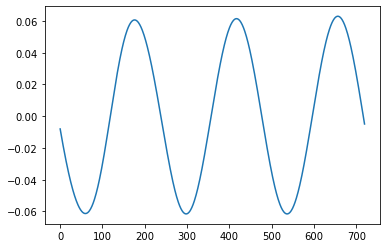

In [ ]:
E_1 = E - np.roll(E,1)
plt.plot(E_1[1:])

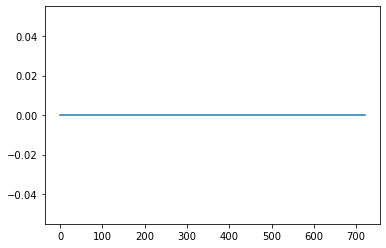

In [ ]:
plt.plot()

In [45]:
np.size(D)

NameError: name 'D' is not defined